## Class 2 - Defining evaluation metrics and fitting basic regression models
In our second lecture, we discussed a number of algorithms and evaluation metrics for regression problems. Today, we will go back to the datasets we looked at last week, and implement some of these algorithms and evaluation metrics on the predictive modeling problems we have defined. 

We will do all of this using `scikit-learn`. A couple of useful pointers to useful documentation, before we start:
- In general, the scikit-learn documentation is your friend: https://scikit-learn.org/stable/
- Here is a list of linear models implemented as Extractors/Predictors in sklearn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
- Here are different forms of neighbor-based models (we talked about `KNNRegressor` yesterday)
- Here are evaluation metrics implemented in sklearn: https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics 
- Here are utilities for preprocessing steps: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing 

**Note**: Under `nbs/class_02` you will find a notebook called `example.ipynb`, where I provide an example of how to run today's exercise on simulated data.

### Today's exercise
Gather in the same or similar groups as last week. Under `class/class_02.md` you will find two predictive modeling questions, one for each datasets. There are different variants of the same questions, which differ in which outcome you want to predict.

What I would like you to do today is the following:
1. Create a folder called `group-x` within `nbs/class_02`, `cd` into it and work within that today
2. Choose an outcome variable for a regression problem. On the basis of this, define **which of the evaluation metrics** could be suitable. Evaluation metrics can be computed using scikit-learn: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics 
3. (a) If you are in the bike sharing group, split your dataset into a training/validation/test set using later time points as validation/test set. Validation and test set should be 15% of your data each. (b) If you are in the personality group, using sklearn's `train_test_split` function, create a 70/15/15 random split of your data.
    - Remember to set a seed (`random_state`) when you do so. Let's all use the same (the classic `random_state=42`)
    - Save these datasets as separate csv files in a subfolder called `data`
4. Look at your outcome and predictors: do you want to transform them in any way?
5. Estimate the performance of a dummy baseline (i.e., the mean model) on all splits
6. Now look at your predictors: do they need any preprocessing? Any transformations? Removal of "bad" data points?
7. Fit the other models using KKN (sklearn's `KNeighborsRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) and linear models (`LinearRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Save the fitted model object (with a meaningful name) using `pickle` (https://scikit-learn.org/stable/model_persistence.html) in a subfolder called `model`.
8. Once you are done, evaluate all models on both the training and the validation set and visualize the scores


### Once you have done this
Please submit a pull request to my repository where, within `nbs/class_02/group-x` you have: 
- the notebook on which you have worked
- a subfolder called `data` containing your splits
- a subfolder called `models` containing your models

In next week's class, I will ask each group to briefly present their results.

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import pickle as pkl

In [4]:
# load the data
data = pd.read_csv("../../data/class_01/bikes.csv")

In [5]:
# look at the data
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Choosing an Evaluation Metric
Based on the fact that we are interested in doing prediction, we are not going to evaluate based on R2. Instead, we opt for Mean Absolute Error as that is more suitable for seeing if our model predicts data well.

In [6]:
# creating the y and X for all models
y = np.array(data["cnt"])
X0 = np.ones(len(y)).reshape(-1,1)
X1 = np.array(data["instant"]).reshape(-1,1)
X2 = np.array(data[["temp", "windspeed", "season", "weekday"]])
X3 = np.array(data[["instant", "season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed"]])

Xs = [X0, X1, X2, X3]

In [7]:
# split the data into train, test and val

# find the points that fit with where the data should be split to get 70/15/15
first_70 = int(len(data) * 0.70)
next_15 = int(len(data) * 0.15 + first_70)

# set empty lists
train_Xs = []
val_Xs = []
test_Xs = []

# fill the lists
for X in Xs:
    # get the train
    train = X[:first_70]
    train_Xs.append(train)

    # get the val
    val = X[first_70:next_15]
    val_Xs.append(val)

    # get the test
    test = X[next_15:]
    test_Xs.append(test)


y_train = y[:first_70]
y_val = y[first_70:next_15]
y_test = y[next_15:]

print(len(train_Xs[0]))
print(len(val_Xs[0]))
print(len(test_Xs[0]))

print(len(y_train))
print(len(y_val))
print(len(y_test))

12165
2606
2608
12165
2606
2608


<Axes: xlabel='cnt', ylabel='Count'>

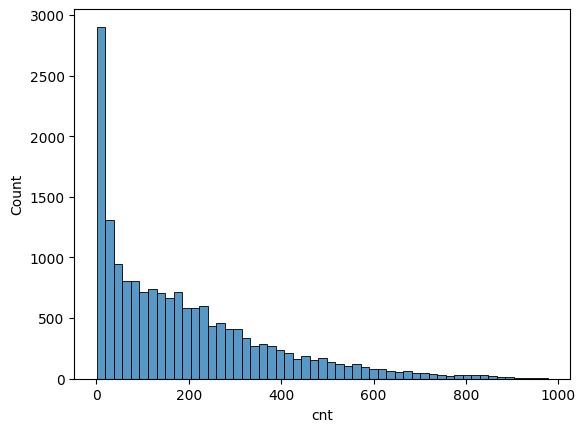

In [8]:
# looking at the distribution of the outcome
sns.histplot(data=data, x="cnt")

### Create and Evaluate Models for Linear Regression

In [11]:

# init list for evals
eval_mae = []

# fit the models
for i in range(len(Xs)):
    # initialize the model
    model = LinearRegression()

    # fit model on the training data
    model.fit(train_Xs[i], y_train)

    # predict on the validation
    X_predict = model.predict(val_Xs[i])

    # evaluate the predictions
    mae = round(mean_absolute_error(X_predict, y_val),2)

    # append score
    eval_mae.append(mae)

    # save model to subfolder
    pkl.dump(model, file=open(f'../../models/class_02/linear-{i}.pkl', 'wb'))

    print(f"MAE score for Linear Regression on X{i}: {mae}")


MAE score for Linear Regression on X0: 194.08
MAE score for Linear Regression on X1: 179.66
MAE score for Linear Regression on X2: 166.05
MAE score for Linear Regression on X3: 155.34


### Create and Evaluate Models for KNN Regression

In [13]:
# repeat the process for KNN regression
# init list for evals
eval_mae = []

# fit the models
for i in range(len(Xs)):
    # initialize the model (10 neighbors)
    model = KNeighborsRegressor(n_neighbors=10)

    # fit model on the training data
    model.fit(train_Xs[i], y_train)

    # predict on the validation
    X_predict = model.predict(val_Xs[i])

    # evaluate the predictions
    mae = round(mean_absolute_error(X_predict, y_val),2)

    # append score
    eval_mae.append(mae)

    pkl.dump(model, file=open(f'../../models/class_02/knn-{i}.pkl', 'wb'))

    print(f"MAE score for KNN Regression on X{i}: {mae}")

MAE score for KNN Regression on X0: 268.89
MAE score for KNN Regression on X1: 181.26
MAE score for KNN Regression on X2: 164.73
MAE score for KNN Regression on X3: 181.47
